In [1]:
import collections
import torch
import json
import os
import cv2
import random
import gc
import pycocotools
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
import os
for dirname, _, filenames in os.walk('/home/pcwu1023/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/label_descriptions.json
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/sample_submission.csv
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/train.csv
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/test/05bfc7156bc37ce44207ca814f1b3737.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/test/07729e318fa891baba6eb212220b95a6.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/test/614e7297f89c14e73b691d7f76ed77f4.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/test/7229de52add8dfb593d50f63cc39df10.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/test/8fb485761d8e4e3f7d0673d317432105.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/train/269fba233e74eef1939cf06c7ce1bc2a.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/train/522fd48098d816399db2669288b8d707.jpg
/home/pcwu1023/kaggle/input/imaterialist-fashion

In [3]:
# https://detectron2.readthedocs.io/tutorials/datasets.html
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

def get_fashion_dict(df):
    
    dataset_dicts = []
    
    for idx, filename in enumerate(df['ImageId'].unique().tolist()):
        
        record = {}
        
        record['height'] = int(df[df['ImageId']==filename]['Height'].values[0])
        record['width'] = int(df[df['ImageId']==filename]['Width'].values[0])
        record['file_name'] = filename
        record['image_id'] = idx
        
        objs = []
        for index, row in df[(df['ImageId']==filename)].iterrows():
            
            # Create binary mask from EncodedPixel, Heigh, and Width columns
            mask = rle_decode_string(row['EncodedPixels'], row['Height'], row['Width'])
            
            # transform the mask from binary to polygon
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)    
            
            obj = {
                'bbox': [row['x0'], row['y0'], row['x1'], row['y1']],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': row['ClassId'],
                'segmentation': segmentation, # polygon mask, as required by Detectron2 documentation
                'iscrowd': 0
            }
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
# Rle helper functions

def rle_decode_string(string, h, w):
    mask = np.full(h*w, 0, dtype=np.uint8)
    annotation = [int(x) for x in string.split(' ')]
    for i, start_pixel in enumerate(annotation[::2]):
        mask[start_pixel: start_pixel+annotation[2*i+1]] = 1
    mask = mask.reshape((h, w), order='F')

    
    return mask

def rle2bbox(rle, shape):
    '''
    Get a bbox from a mask which is required for Detectron 2 dataset
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    
    Note on image vs np.array dimensions:
    
        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1

In [5]:
data_dir = Path('/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/')
image_dir = Path('/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/train/')
df = pd.read_csv(data_dir/'train.csv')

# Get label descriptions
with open(data_dir/'label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
df_categories = pd.DataFrame(label_desc['categories'])
df_attributes = pd.DataFrame(label_desc['attributes'])

In [6]:
# Get image file path and add it to our dataframe
dirname = '/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/train'
#df_copy = df[:40000].copy()
df_copy = df[:3000].copy()
df_copy['ImageId'] = dirname + '/' + df_copy['ImageId'] + '.jpg'
# Get bboxes for each mask
bboxes = [rle2bbox(c.EncodedPixels, (c.Height, c.Width)) for n, c in df_copy.iterrows()]

In [7]:
assert len(bboxes) == df_copy.shape[0]
bboxes_array = np.array(bboxes)
# Add each coordinate as a column
df_copy['x0'], df_copy['y0'], df_copy['x1'], df_copy['y1'] = bboxes_array[:,0], bboxes_array[:,1], bboxes_array[:,2], bboxes_array[:,3]

In [8]:
del bboxes
gc.collect()

64

In [9]:
df_copy.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,x0,y0,x1,y1
0,/home/pcwu1023/kaggle/input/imaterialist-fashi...,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",1163,3923,2839,5213
1,/home/pcwu1023/kaggle/input/imaterialist-fashi...,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",1212,1371,2394,3979
2,/home/pcwu1023/kaggle/input/imaterialist-fashi...,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163,1634,1371,2394,1892
3,/home/pcwu1023/kaggle/input/imaterialist-fashi...,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204",2474,1827,3309,4603
4,/home/pcwu1023/kaggle/input/imaterialist-fashi...,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219,2078,2509,2577,2663


In [10]:
fashion_dict = get_fashion_dict(df_copy[:50])
# Get a sample of the training data to run experiments
df_copy_sample = df_copy[:2400].copy()
df_sample_test = df_copy[2401:3000].copy()

In [11]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Register the train and test and set metadata
for d in ['train']:
    DatasetCatalog.register('sample_fashion_' + d, lambda d=df_copy_sample: get_fashion_dict(d))
    MetadataCatalog.get("sample_fashion_" + d).set(thing_classes=list(df_categories.name))
fashion_metadata = MetadataCatalog.get("sample_fashion_train")
for d in ['test']:
    DatasetCatalog.register('sample_fashion_' + d, lambda d=df_sample_test: get_fashion_dict(d))
    MetadataCatalog.get("sample_fashion_" + d).set(thing_classes=list(df_categories.name))
fashion_metadata = MetadataCatalog.get("sample_fashion_test")

## Try pretrain model

45623


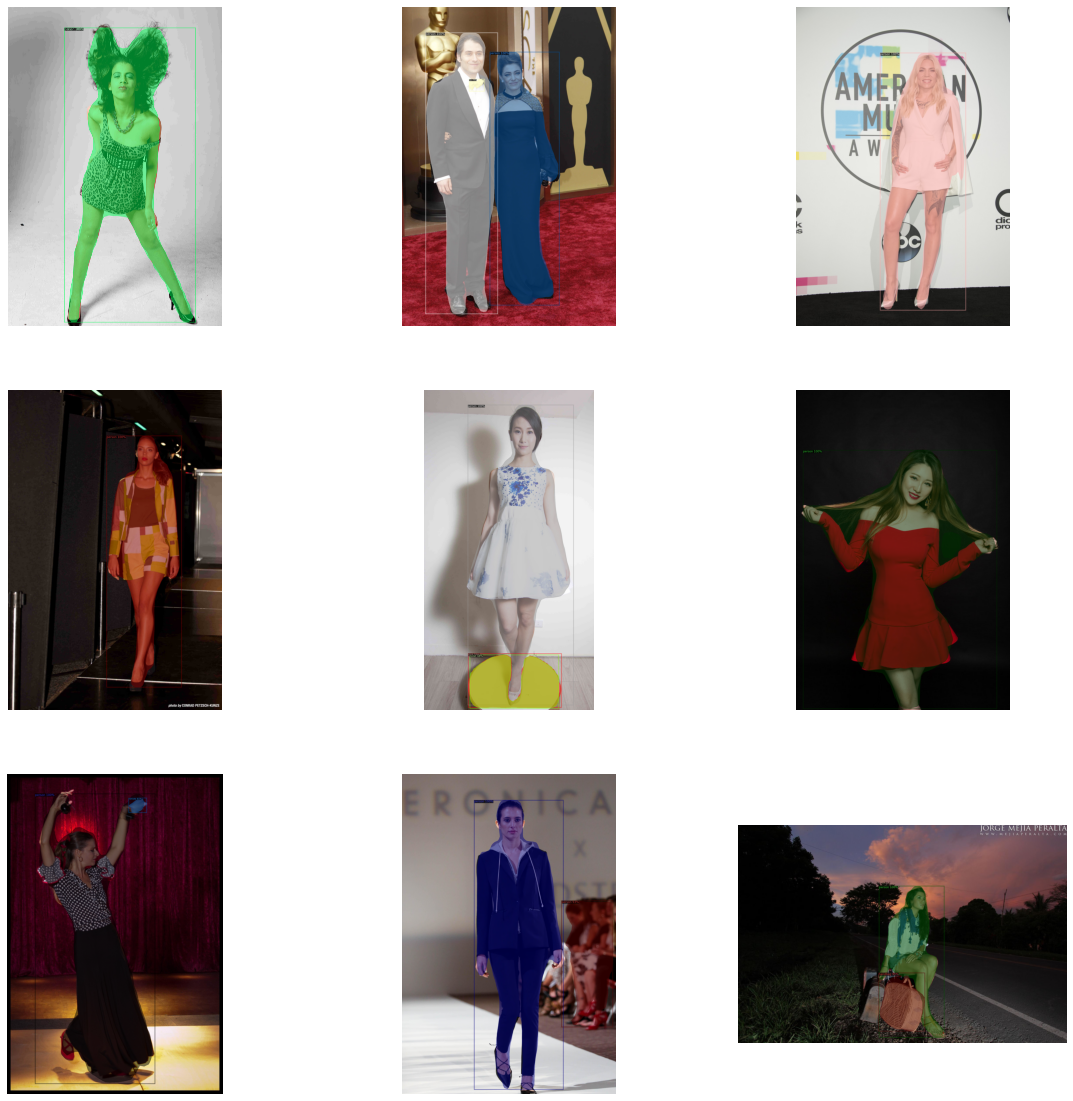

In [12]:
cfg = get_cfg()
# Merging model configs with default 
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Get weights from Instance segmentation Mask RCNN R 50 FPN model
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

images_list = []
for dirname, _, filenames in os.walk('/home/pcwu1023/kaggle/input/imaterialist-fashion-2020-fgvc7/train'):
    for filename in filenames:
        images_list.append(os.path.join(dirname, filename))
print(len(images_list))

# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, image in enumerate(random.sample(images_list, 9)):
    
    # Process image
    im = cv2.imread(image)
    plt.subplot(rows, cols, i+1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.axis('off')
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()

## Training

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# create different configuration 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample_fashion_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo


##### Input #####
# Set a smaller image size than default to avoid memory problems

# Size of the smallest side of the image during training
cfg.INPUT.MIN_SIZE_TRAIN = (400,)
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = 600
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = 400
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 600

# Mask type
#cfg.INPUT.MASK_FORMAT = "bitmask"  # default: "polygon"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 3000 # not enough iterations for real training, but this is just a demo    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # default: 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 46  # 46 classes in iMaterialist

In [14]:
cfg.OUTPUT_DIR = 'mask_rcnn_X_101_32x8d_FPN_3x'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [15]:
trainer = DefaultTrainer(cfg) 

[06/03 01:06:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
trainer.resume_or_load(resume=False)

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (47, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (47,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (184, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (184,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (46, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (46,) in the model! Skipped.


In [17]:
trainer.train()

[06/03 01:07:54 d2.engine.train_loop]: Starting training from iteration 0
[06/03 01:08:29 d2.utils.events]:  eta: 1:19:43  iter: 19  total_loss: 6.300  loss_cls: 3.730  loss_box_reg: 0.784  loss_mask: 0.693  loss_rpn_cls: 0.982  loss_rpn_loc: 0.102  time: 1.6711  data_time: 0.1153  lr: 0.000005  max_mem: 2991M
[06/03 01:09:00 d2.utils.events]:  eta: 1:18:43  iter: 39  total_loss: 6.679  loss_cls: 3.602  loss_box_reg: 0.803  loss_mask: 0.693  loss_rpn_cls: 1.282  loss_rpn_loc: 0.153  time: 1.6208  data_time: 0.0099  lr: 0.000010  max_mem: 2991M
[06/03 01:09:33 d2.utils.events]:  eta: 1:18:02  iter: 59  total_loss: 6.017  loss_cls: 3.344  loss_box_reg: 0.678  loss_mask: 0.691  loss_rpn_cls: 0.998  loss_rpn_loc: 0.130  time: 1.6222  data_time: 0.0709  lr: 0.000015  max_mem: 2991M
[06/03 01:10:06 d2.utils.events]:  eta: 1:17:28  iter: 79  total_loss: 5.205  loss_cls: 2.996  loss_box_reg: 0.771  loss_mask: 0.691  loss_rpn_cls: 0.625  loss_rpn_loc: 0.149  time: 1.6306  data_time: 0.0952  lr:

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model

cfg.DATASETS.TEST = ('sample_fashion_test',)# set test dataset
predictor = DefaultPredictor(cfg)

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
#model = build_model(cfg)
#file_path='/home/pcwu1023/cs231n-project/experiments/detectron_way/output/model_final.pth'
#DetectionCheckpointer(model).load(file_path)
evaluator = COCOEvaluator("sample_fashion_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "sample_fashion_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [06/03 02:28:21 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'sample_fashion_test'. Trying to convert it to COCO format ...
[06/03 02:28:21 d2.data.datasets.coco]: Converting annotations of dataset 'sample_fashion_test' to COCO format ...)
[06/03 02:28:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/03 02:28:31 d2.data.datasets.coco]: Conversion finished, #images: 80, #annotations: 599
[06/03 02:28:31 d2.data.datasets.coco]: Caching COCO format annotations at 'mask_rcnn_X_101_32x8d_FPN_3x/sample_fashion_test_coco_format.json' ...
[06/03 02:28:42 d2.data.build]: Distribution of instances among all 46 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| shirt, blouse | 11           | top, t-shir.. | 29           |  sweater   | 4            |
|   cardigan    | 3            |    ja

OrderedDict([('bbox',
              {'AP': 14.326885699396543,
               'AP50': 24.634527749419746,
               'AP75': 16.117646230614145,
               'APs': 8.0768509543262,
               'APm': 13.531878016373481,
               'APl': 19.26867626524115,
               'AP-shirt, blouse': 8.771661676178153,
               'AP-top, t-shirt, sweatshirt': 20.52821418952481,
               'AP-sweater': 0.0,
               'AP-cardigan': 3.0445544554455446,
               'AP-jacket': 33.2713398078764,
               'AP-vest': 0.0,
               'AP-pants': 61.79278391445904,
               'AP-shorts': 29.15940074250586,
               'AP-skirt': 21.061559691563993,
               'AP-coat': 31.968664970228293,
               'AP-dress': 55.658636691624174,
               'AP-jumpsuit': 0.0,
               'AP-cape': nan,
               'AP-glasses': 30.47426801503679,
               'AP-hat': 9.050669772859637,
               'AP-headband, head covering, hair accessory

## Show image using trained predictor

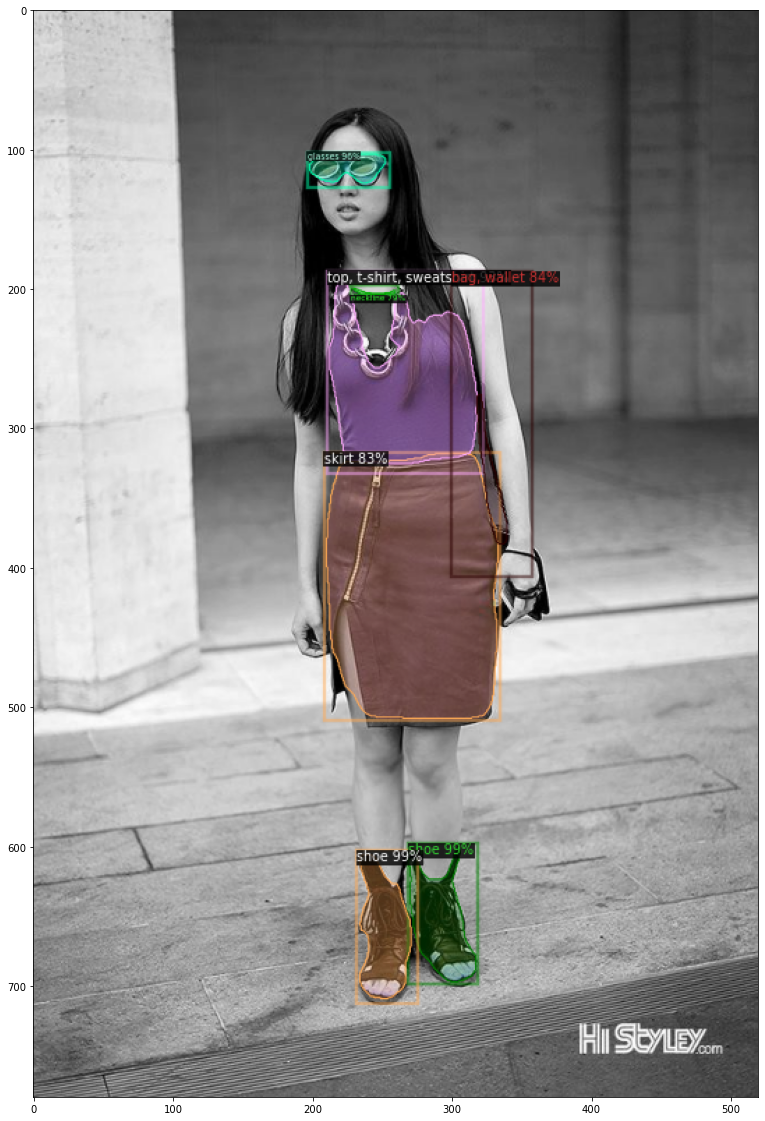

In [20]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(fashion_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

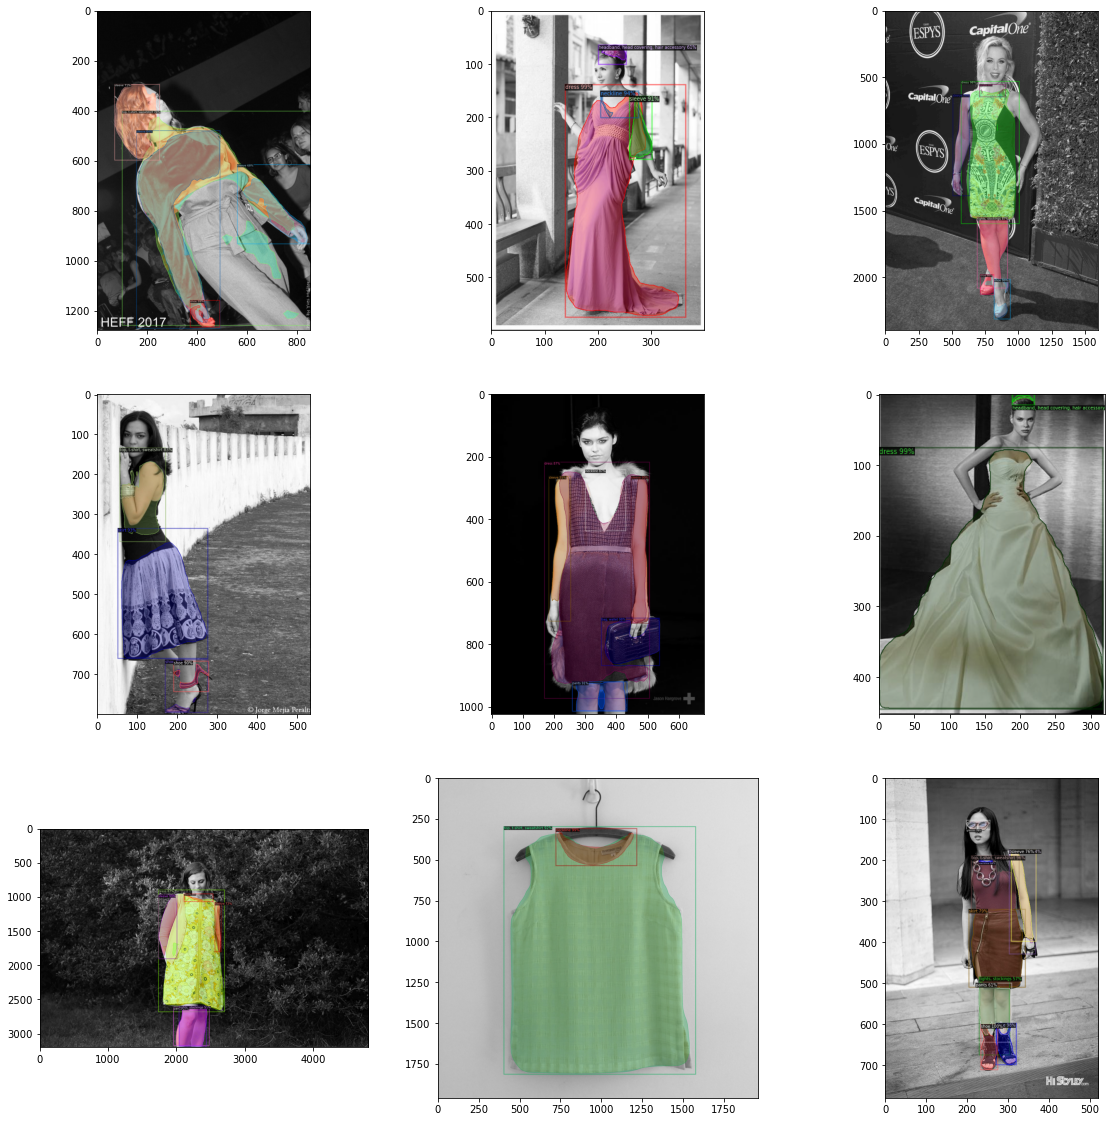

In [21]:
# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, d in enumerate(random.sample(fashion_dict, 9)):
    
    # Process image
    plt.subplot(rows, cols, i+1)

    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=fashion_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()